In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from src.policy import jaccard_distance
from src import utils
import pickle

### Load and process data

In [2]:
def load_experiments(filename):
    f = open(filename, "rb")
    results = pickle.load(f)
    return results[0], results[1::]

def merge_runs(old, new, min_merge=False):
    if len(old) == len(new) or (len(old) < len(new) and min_merge):
        for i in range(len(old)):
            old[i] += new[i]
    else:
        raise Exception("Cannot merge")
    return old

In [4]:
filenames = ["experiments/results_1580578327_n_workers:-1_debug:False_avg_deg:2_G:10_runs:10_n_min:8_n_max:8_w_min:0.1_w_max:0.2_var_min:0.1_var_max:1_int_min:0_int_max:1_random_state:42.pickle"]
#"experiments/results_1578416635_n_workers:99_seq:False_debug:False_avg_deg:1.5_G:100_runs:10_n_min:8_n_max:15_w_min:1_w_max:2_var_min:0.1_var_max:1_int_min:0_int_max:1_random_state:42.pickle",
#"experiments/results_1578415843_n_workers:99_seq:False_debug:False_avg_deg:2.0_G:100_runs:10_n_min:8_n_max:15_w_min:1_w_max:2_var_min:0.1_var_max:1_int_min:0_int_max:1_random_state:42.pickle",
#"experiments/results_1578419554_n_workers:99_seq:False_debug:False_avg_deg:2.5_G:100_runs:10_n_min:8_n_max:15_w_min:1_w_max:2_var_min:0.1_var_max:1_int_min:0_int_max:1_random_state:42.pickle",
#"experiments/results_1578415177_n_workers:99_seq:False_debug:False_avg_deg:3.0_G:100_runs:10_n_min:8_n_max:15_w_min:1_w_max:2_var_min:0.1_var_max:1_int_min:0_int_max:1_random_state:42.pickle",
#"experiments/results_1578414963_n_workers:99_seq:False_debug:False_avg_deg:3.5_G:100_runs:10_n_min:8_n_max:15_w_min:1_w_max:2_var_min:0.1_var_max:1_int_min:0_int_max:1_random_state:42.pickle"
#]
cases, results = load_experiments(filenames[0])
if len(filenames) > 1:
    for filename in filenames[1::]:
        print("Loading %s" % filename)
        _, loaded = load_experiments(filename)
        for k in range(len(results)):
            results[k] = merge_runs(results[k], loaded[k])
max_iter = 15

In [173]:
mask = []
for i, case in enumerate(cases):
    mb = utils.graph_info(case.target, case.sem.W)[3]
    if len(mb) > 1:
        mask.append(i)
#cases = [cases[i] for i in mask]
mask = None

all_experiments = list(reduce(lambda acc, batch: acc + batch, results[0][0]))
results = []
for p in range(3):
    policy_results = []
    for r in range(32):
        start = p*32000 + r * 1000
        run_results = all_experiments[start:start+1000]
        if mask is None:
            policy_results.append(run_results)
        else:
            run_results = [run_results[i] for i in mask]
        policy_results.append(run_results)
    results.append(policy_results)

In [5]:
def hamming_distance(A,B,p):
    a = np.zeros(p)
    b = np.zeros(p)
    a[list(A)] = 1
    b[list(B)] = 1
    return scipy.spatial.distance.hamming(a, b)

In [11]:
colorsa = np.array(["#ff7878", "#ffbc78", "#ffff78", "#bcff78", "#78ffbc"])
colorsb = np.array(["#f2ffc1", "#beffa4", "#8ff2af", "#14e3b4", "#00b2ad"])
markers = np.array(["o", "*", "+"])
    
runs = len(results[0])
N = len(results[0][0])
P = len(results)

no_ints = np.zeros((len(results), runs, N))
all_trajectories_jac = {}
all_trajectories_ham = {}
names = []
for k, policy_runs in enumerate(results):
    name = policy_runs[0][0].policy
    names.append(name)
    trajectories_jac = []
    trajectories_ham = []
    for i,run_results in enumerate(policy_runs):
        no_ints[k, i,:] = list(map(lambda result: len(result.interventions()), run_results))
        for j, result in enumerate(run_results):
            estimates = list(map(lambda step: step[0], result.history[1::])) + [result.estimate]
            trajectory_jac = list(map(lambda estimate: jaccard_distance(cases[j].truth, estimate), estimates))
            trajectory_ham = list(map(lambda estimate: hamming_distance(cases[j].truth, estimate, cases[j].sem.p), estimates))
            trajectories_jac.append(trajectory_jac)
            trajectories_ham.append(trajectory_ham)
    all_trajectories_jac[name] = trajectories_jac
    all_trajectories_ham[name] = trajectories_ham

**Summary of graphs used**

In [12]:
n_parents = np.zeros(N)
n_vars = np.zeros(N)
size_mb = np.zeros(N)
for i, case in enumerate(cases):
    n_parents[i] = len(case.truth)
    n_vars[i] = case.sem.p
    mb = utils.graph_info(case.target, case.sem.W)[3]
    size_mb[i] = len(mb)

def plot_hist(data, title):
    bins = np.arange(data.min(), data.max()+2)-0.5
    hist = plt.hist(data, bins, rwidth=0.5, align='mid')
    plt.title(title)

10 graphs in total


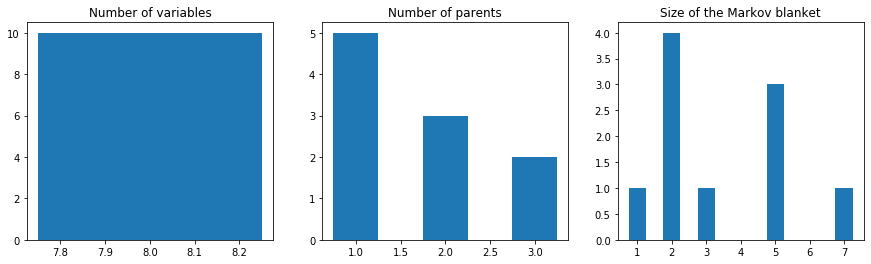

In [13]:
plt.figure(figsize=(15,4))
plt.subplot(131), plot_hist(n_vars, "Number of variables")
plt.subplot(132), plot_hist(n_parents, "Number of parents")
plt.subplot(133), plot_hist(size_mb, "Size of the Markov blanket")
print("%d graphs in total" % N)

### Hamming Distance

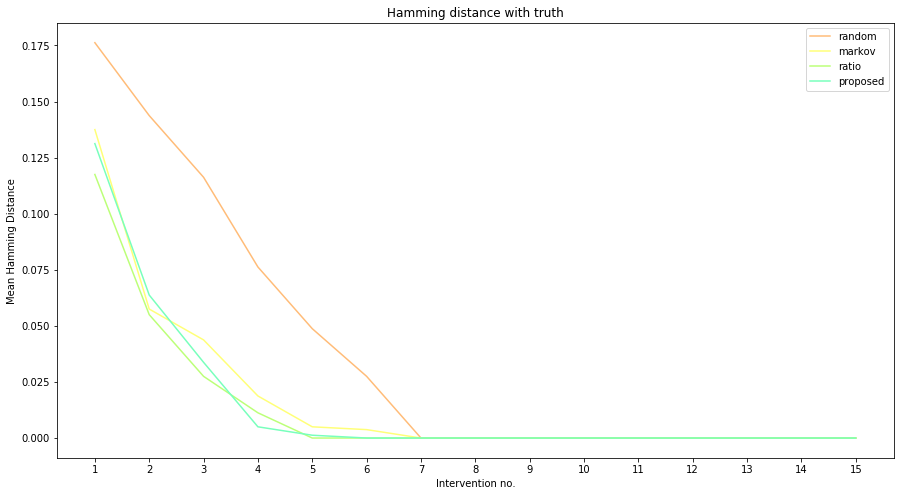

In [17]:
hm_dist = np.zeros((P, N*runs, max_iter))
for i, (name, trajectories) in enumerate(all_trajectories_ham.items()):
    for j, trajectory in enumerate(trajectories):
        hm_dist[i, j, 0:len(trajectory)] = trajectory

mean = np.mean(hm_dist, axis=1)

x_axis = np.arange(1, max_iter+1)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
policy_names 
plt.plot(x_axis, mean[3,:], label="random", color=colorsa[1])
plt.plot(x_axis, mean[0,:], label="markov", color=colorsa[2])
plt.plot(x_axis, mean[1,:], label="ratio", color=colorsa[3])
plt.plot(x_axis, mean[2,:], label="proposed", color=colorsa[4])
plt.xlabel("Intervention no.")
plt.ylabel("Mean Hamming Distance")
plt.title("Hamming distance with truth")
axes.set_xticks(x_axis)
plt.legend()

### Number of interventions required

[Text(0, 0, 'random'), Text(0, 0, 'markov blanket'), Text(0, 0, 'ratio')]

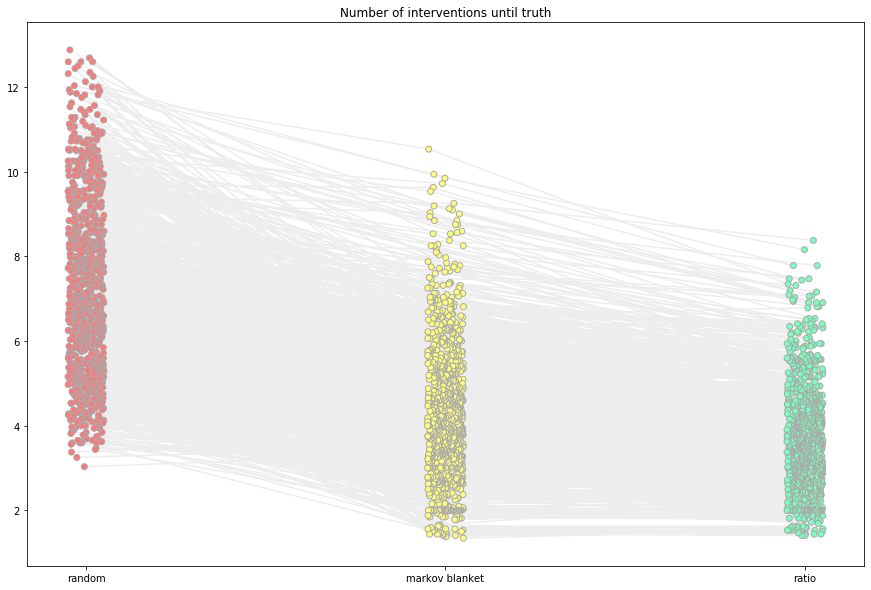

In [171]:
means = np.mean(no_ints, axis=1)
plt.figure(figsize = (15,10))
dev = 0.05
xaxis = np.tile([0,1,2], (N, 1)) - np.outer(np.linspace(-dev, dev, N), [1,1,1])
ecolor = "#ededed"
for i in range(N):
    plt.plot(xaxis[i,:], means[[2,0,1], i].T, color=ecolor, zorder=0)
for i in range(N):
    plt.scatter(xaxis[i,:], means[[2,0,1], i].T, c=colorsa[[0,2,4]], marker="o", zorder=1, edgecolors="#aaaaaa")
plt.title("Number of interventions until truth")
ax = plt.gca()
ax.set_xticks([0,1,2])
ax.set_xticklabels(["random", "markov blanket", "ratio"])

In [62]:
#idx, = np.where(no_ints[2,:,:].mean(axis=0) > 1)
idx = np.arange(32)
Ns = len(idx)

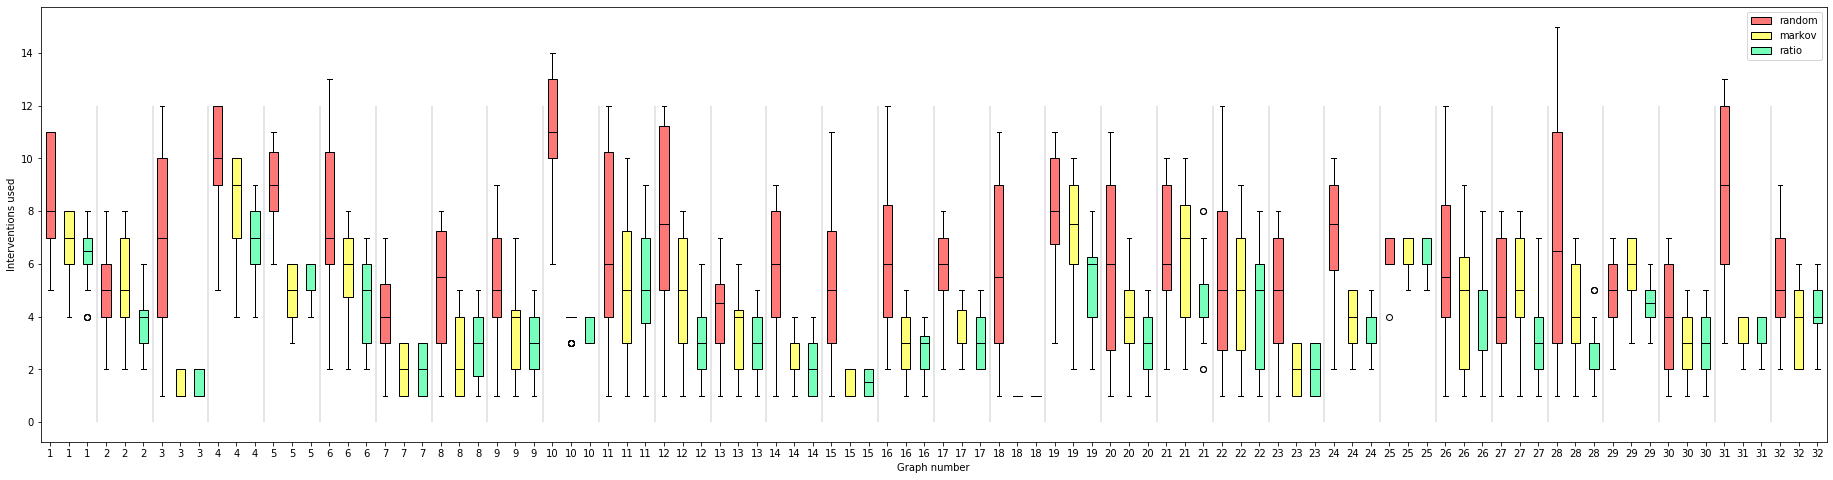

In [63]:
all_data = np.zeros((runs,Ns*3))
all_data[:, 0:Ns*3:3] = no_ints[2,:,idx].T
all_data[:, 1:Ns*3:3] = no_ints[0,:,idx].T
all_data[:, 2:Ns*3:3] = no_ints[1,:,idx].T
labels = (np.floor(np.arange(0,Ns*3) / 3) + 1).astype(int)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(32, 8))
bplot = axes.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,
                     medianprops = {'color': 'black'},
                     labels = labels)
for i,patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colorsa[(i % 3*2)])
plt.xlabel("Graph number")
plt.ylabel("Interventions used")
plt.legend(bplot['boxes'][0:3], ['random', 'markov', 'ratio']);
for i in range(Ns):
    x = i*3+0.5
    plt.plot([x,x], [0,12], c='black', LineWidth=0.2)